# **Chap3：卷积神经网络**

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

In [ ]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
# utils.gpu_limitation_config(memory=12)

## **3.2 卷积神经网络**

### **3.2.1 从全连接网络到卷积**

到此为止我们所学习的**全连接神经网络MLP适合处理表格类型的数据**（即 $X\in \mathbb{R}^{N\times p}$，每一行代表一个样本，每个样本具有 $p$ 个特征），对于表格数据：
* 我们**不能预先假设任何与特征交互相关的先验结构**
* 全连接网络此时可能是最好的选择，它让特征之间充分交互

而在面对图像这种高维非结构化数据时，缺少结构的神经网络模型可能会变得不实用，例如：
* 一方面，日常生活中的图像大小可能达到百万像素，此时如果利用全连接神经网络，即使第一层隐藏层将特征维度压缩至1000，第一层的参数量就有 $10^6 \times 10^3 \approx 10^9$，**如此巨大的参数量会使得模型的训练变得非常困难，难以实现**
* 图像数据，对于**相邻的像素，特征的相关性是很高的**，而当我们将图像“拉直”后送入全连接网络，**破坏了图像特征中存在的空间结构信息**，导致模型学习效果不理想

人们针对图像中包含的丰富的结构特点，设计了**卷积神经网络**（**convolutional neural networks**，**CNN**），他能有效的提取图像数据的特征，是**机器学习计算机视觉领域**中一种非常有效的，创新性的模型结构

### **3.2.2 卷积神经网络假设**

假设我们想从一张图片中找到某个物体。 合理的假设是，**无论哪种方法找到这个物体，都应该和物体在图片中的位置无关**，因此，模型应该尝试将图片**打散为不同的区域**，对**每一区域的图像进行局部检查**，卷积神经网络基于此设计了两条最重要的假设：
* **平移不变性**（**translation invariace**)：不管检测核心目标出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像具有相似的反应
* **局部性**（**locality**）：神经网络的**前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系**，最终，模型可以聚合这些局部特征，以在整个图像级别进行预测

下面我们讨论这些性质如何转换为数学表示

考虑将输入 $\boldsymbol{X}\in\mathbb{R}^{H\times W}$ 通过参数变换 $\boldsymbol{W}$ 映射到隐藏层 $\boldsymbol{H}\in\mathbb{R}^{p\times q}$，这里我们假设映射后的隐藏层 $\boldsymbol{H}$ 依然保持二维结构，但事实上全连接网络是将 $\boldsymbol{X}$ 映射到一维向量，这不是本质的区别，注意表达式：

$$
\boldsymbol{H}_{i,j} = \boldsymbol{B}_{i,j} + \sum_{k}\sum_{l} \boldsymbol{W}_{i,j,k,l}\boldsymbol{X}_{k,l}
$$

其中，$\boldsymbol{B}_{i,j}$ 是偏置项，权重 $\boldsymbol{W}_{i,j,k,l}$ 被写为四维张量，前两个维度 $(i,j)$ 用来索引隐藏层神经元，后面两个维度 $(k,l)$ 用来索引输入图像 $\boldsymbol{X}$ 的像素坐标，对于固定的下标 $(i,j)$，我们可以重新索引下标 $(k,l)$，使得 $k=i+a,l=j+b$，则：

$$
\boldsymbol{H}_{i,j} = \boldsymbol{B}_{i,j} + \sum_{a}\sum_{b} \boldsymbol{V}_{i,j,a,b}\boldsymbol{X}_{i+a,j+b}
$$

其中，$\boldsymbol{V}_{i,j,a,b}=\boldsymbol{W}_{i,j,i+a,j+b}$，索引 $(a,b)$ 通过在正偏移和负偏移之间移动覆盖了整个图像，可以理解为，对于隐藏层位置 $(i,j)$ 处的像素 $\boldsymbol{H}_{i,j}$，可以通过在 $\boldsymbol{X}$ 中以 $(i,j)$ 为中心对像素进行加权求和得到，权重矩阵为 $\boldsymbol{V}_{i,j,a,b}$

上述计算过程如下图所示：

<img src="./source/Chap3/卷积全连接.png" width=1000>

**(1) 平移不变性**

当目标像素 $(i,j)$ 在图像 $\boldsymbol{X}$ 发生平移时：$(i,j)\to (i+s,j+r)\equiv (i',j')$，应该**仅导致隐藏单元** $\boldsymbol{H}$ **中对应部分的平移**，简单来说，**权重** $\boldsymbol{V}$ **和偏置** $\boldsymbol{B}$ **实际上不应该依赖索引** $(i,j)$ **的值**，此时 $\boldsymbol{B}$ 应该作为一个常数 $b$，因此，隐藏单元的计算为：

$$
\boldsymbol{H}_{i,j} = b + \sum_{a}\sum_{b} \boldsymbol{V}_{a,b}\boldsymbol{X}_{i+a,j+b}
$$

事实上，上述运算在数学上可以视作**离散卷积**，其中与 $(i,j)$ 无关的权重 $\boldsymbol{V}$ 可以当作**卷积算子**，它将输入图像 $\boldsymbol{X}$ 在位置 $(i,j)$ 附近的像素 $(i+a,j+b)$ 进行加权得到 $\boldsymbol{H}_{i,j}$
* 注意权重 $\boldsymbol{V}_{a,b}$ 要比 $\boldsymbol{V}_{i,j,a,b}$ 的参数少很多，因为**前者不依赖于图像中的位置** $(i,j)$

数学上，两个函数 $f,g:\mathbb{R}^p\to \mathbb{R}$ 之间的卷积定义为：
$$
(f*g)(x) = \int {f(z)g(x-z) dz}
$$

离散场合下，积分变为求和，卷积的定义为：
$$
(f*g)(i) = \sum_{j} f(j)g(i-j)
$$

当 $f,g$ 是二元函数时，离散卷积的形式就更接近我们定义的图像卷积：
$$
(f*g)(i,j) = \sum_{a}\sum_{b} f(a,b)g(i-a,j-b)
$$

**卷积运算统计了当把一个函数** $g$ **翻转并在每个坐标上移位后**，**与函数** $f$ **之间的“重叠”情况**，从符号看出，图像卷积的计算并没有像数学定义中那样对 $g$ 进行翻转，但这些区别是表面的，并非本质，图像卷积的定义更接近**互相关函数**

**(2) 局部性**

局部性意味着，对于输入图像 $\boldsymbol{X}$ 在位置 $(i,j)$ 处特征的提取，从而映射得到 $\boldsymbol{H}_{i,j}$ 时，不应该考虑距离 $(i,j)$ 太远的信息，这意味着当 $|a|, |b| > \Delta$ 时，可以设置 $\boldsymbol{V}_{a,b} = 0$，或者等价的：

$$
\boldsymbol{H}_{i,j} = b + \sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta} \boldsymbol{V}_{a,b}\boldsymbol{X}_{i+a,j+b}
$$

上式即为神经网络中的**卷积层**（**convolutional layer**），卷积神经网络CNN就是包含卷积计算曾在内的一类特殊的神经网络

在深度学习中，$\boldsymbol{V}$ 被称为**卷积核**（**convolution kernal**）或者**滤波器**（**filter**），它是一种算子，**其值即为该卷积算子的权重，这些参数在CNN中是可学习的参数**

当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示网络中的一层，而现在**卷积神经网络通常只需要几百个参数**，而且**不需要改变输入或隐藏层的维数**，这种设计有两个潜在的问题：
* 我们现在假设了输入 $\boldsymbol{X}$ 的特征是平移不变的，并且当 $\boldsymbol{V}$ 确定时，**这种隐藏层特征提取只包含局部信息，而全连接层的每一个计算单元都包含来自上一层的所有信息**
* 这种模型结构依赖**归纳偏置**，或者叫**数据特征的先验假设**，当数据特征符合我们提出的两条假设（**平移不变性**和**局部性**）时，模型能取得很好的结果，但当假设不成立时，模型的性能就可能大幅下滑

**(3) 图像通道**

上面的讨论忽略了图像的通道信息，即R, G, B这三个颜色通道，因此，通常来说图像输入不是二维张量，而是**由高度，宽度和颜色组成的三维张量**，对于灰度图像，我们也可以抽象为其拥有一个颜色通道，即 $\boldsymbol{X}\in\mathbb{R}^{H\times W\times 1}$

三维张量中，**前两个维度与像素的空间位置有关**，而**第三个维度可以看作每个像素的多维表示（多特征信息）**，因此，输入特征可以通过 $(i,j,k)$ 来索引 $\boldsymbol{X}_{i,j,k}$，卷积核 $\boldsymbol{V}$ 也相应调整到多个维度：
$$
\boldsymbol{V}_{a,b} \to \boldsymbol{V}_{a,b,c}
$$

新增加的维度 $c$ 表示，**对于输入层** $\boldsymbol{X}$ **的不同通道** $c$，**应该使用不同的卷积核**

由于输入图像是三维张量，我们的**隐藏单元也可以设计为三维张量**，即对于每一个空间位置 $(i,j)$，我们想要得到一组 $\boldsymbol{H}_{i,j,d}$ 而不只是一个隐藏表示 $\boldsymbol{H}_{i,j}$，这样一组隐藏表示（总计 $d$ 个）可以想象为一些互相堆叠的二维隐藏单元 $\boldsymbol{H}_{i,j}$：

$$
\boldsymbol{H}_{i,j,d} = \sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta}\sum_{c} \boldsymbol{V}_{a,b,c,d}\boldsymbol{X}_{i+a,j+b,c}
$$

此时，隐藏表示 $\boldsymbol{H}_{i,j,d}$ 成为了**一系列具有二维张量的通道特征**（总计 $d$ 个通道），这些通道有时也被称为**特征映射**（**feature maps**），每个通道都向后续层提供一组空间化的三维特征张量 $\boldsymbol{H}_{i,j,d}$，直观上可以想象在靠近输入的底层，**一些通道专门识别边缘，而一些通道专门识别纹理**

我们对卷积核 $\boldsymbol{V}_{a,b,c,d}$ 这个四维张量的角标进行解释：
* 前两个维度 $(a,b)$ 用于索引图像的像素位置
* **维度** $c$ **表示卷积输入层的通道数量**，例如原始RGB图像，通道数量 3 个，每个通道使用自己的卷积核参数
* **维度** $d$ **表示卷积输出层的通道数量**，设计多个输出通道的目的在于，针对同一个像素 $(i,j)$，我们想要得到一组而不只是一个隐藏表示，**你可以将它想象为另外一种全连接层**，即针对每个像素 $(i,j)$，以前该像素拥有 $c$ 个特征进行表示，现在我们需要将 $c$ 个特征映射到新的 $d$ 个维度的特征

以上就是**卷积神经网络的基本设想**，但这距离**成为可用的神经网络模型还有很多细节问题需要解决**，下面具体介绍CNN中的每个计算曾，以及其所起到的作用

### **3.2.3 卷积神经网络算子**

**(1) 图像卷积**

在卷积运算中，输入张量 $\boldsymbol{X}\in\mathbb{R}^{H\times W\times c}$ 通过与卷积核 $\boldsymbol{V}$ 进行互相关运算产生三维输出张量，首先忽略输入和输出的第三个通道维度，卷积的计算过程如下图所示：

<img src="./source/Chap3/卷积算子示意图.png" width=900>

整个运算过程类似于，**我们将整个卷积核** $\boldsymbol{V}$ **放到输入** $\boldsymbol{X}$ **上**，**从左上角到右下角，依次按照 1 个像素的距离滑动**，每滑动到一个位置时，进行**互相关的计算（加权求和）**，得到隐藏单元的对应输出

注意到，这种卷积计算**输出的大小会略小于输入大小**，这是因为卷积核 $\boldsymbol{V}$ 的宽度和高度大于 1，而我们需要足够的空间在图像上“移动”卷积核，假设输入图像的大小是 $n_h\times h_w$，卷积核的大小为 $k_h\times k_w$，则**隐藏输出的大小**为：

$$
(n_h - k_h + 1) \times (n_w - k_w + 1)
$$

下面的函数`corr2d()`实现了上述的卷积计算

In [2]:
def corr2d(X : tf.Tensor, kernel : tf.Tensor):
    """
    二维矩阵的互相关运算
    """
    n_h, n_w = X.shape
    k_h, k_w = kernel.shape
    Y = tf.Variable(tf.zeros((n_h - k_h + 1,n_w - k_w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j].assign(tf.reduce_sum(X[i:i+k_h, j:j+k_w] * kernel))
    return Y

In [3]:
# 创建输入 X 和卷积核 Kernal
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
kernel = tf.constant([[0.0, 1.0], [2.0, 3.0]])
# 进行互相关运算
H = corr2d(X,kernel)
print("输入 X: \n",X)
print("卷积核 kernel: \n",kernel)
print("输出 H: \n",H)

输入 X: 
 tf.Tensor(
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]], shape=(3, 3), dtype=float32)
卷积核 kernel: 
 tf.Tensor(
[[0. 1.]
 [2. 3.]], shape=(2, 2), dtype=float32)
输出 H: 
 <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[19., 25.],
       [37., 43.]], dtype=float32)>


当然，我们可以将上面定义的互相关函数`corr2d()`定义为模型中的一个计算层

In [4]:
class MyConv2d(tf.keras.layers.Layer):
    def __init__(self, kernel_size, bias : bool=True, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        # 继承自 tf.keras.layers.Layer 的类可以使用 self.add_weight 添加参数
        # 当然，你也可以使用 tf.Variable 自己初始化定义参数
        self.weight = self.add_weight(name="w", shape=kernel_size)

        # 是否使用偏置项
        if bias:
            self.bias = self.add_weight(name="b",shape=(1,))
        else:
            self.bias = 0
    
    def call(self, inputs, *args, **kwargs):
        return corr2d(inputs, self.weight) + self.bias

In [5]:
layer = MyConv2d(kernel_size=(2,2))
layer.weight # 查看权重参数

<tf.Variable 'w:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.20165396, -0.98051244],
       [-0.73616934,  0.34253228]], dtype=float32)>

In [6]:
layer(X) # 计算结果

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.79646814, -2.3722715 ],
       [-5.5238786 , -7.0996814 ]], dtype=float32)>

我们下面来看一个图像中**边缘检测**的例子，我们在 $[-2,2]\times [-2,2]$ 的坐标中创建一个圆 $x^2 + y^2 \leq 1$

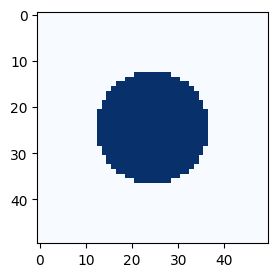

In [7]:
X, Y = np.linspace(-2,2,50), np.linspace(-2,2,50)
X, Y = np.meshgrid(X,Y)
image = np.zeros_like(X)
image[X**2 + Y**2 <= 1] = 1 # 创建原 x^2 + y^2 <= 1
# 展示图像
fig = plt.figure(figsize=(3,3))
plt.imshow(image,cmap=plt.cm.Blues)

接下来，我们定义一个 $1\times 2$ 的卷积核 $K = [1,-1]$，它能够实现**图像中垂直边缘的检测**

In [8]:
# 创建卷积核
kernel = tf.constant([[1.0, -1.0]])
H = corr2d(X=tf.constant(image,dtype=tf.float32),kernel=kernel)

我们绘制卷积运算处理后，隐藏层的图像 $H$，可以清楚地看到，**该卷积核能够清楚识别图像中的垂直边缘**

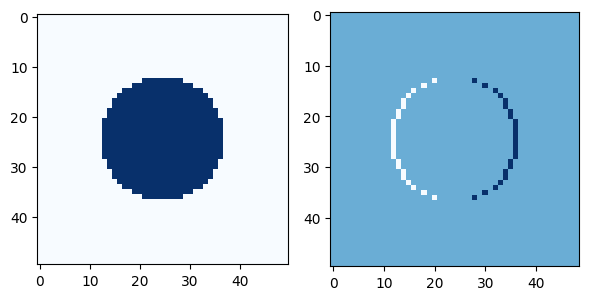

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax = ax.flatten()
ax[0].imshow(image,cmap=plt.cm.Blues) # 原始图像
ax[1].imshow(H.numpy(),cmap=plt.cm.Blues) # 卷积核运算后的结果
plt.tight_layout()

更重要的是，**神经网络中的卷积核的参数是可以学习的**，因此这些**卷积核通过损失函数引导，以获得不同的特征提取能力**

我们通过`tf.keras.layers.Conv2d()`创建卷积层，来**尝试学习上面的垂直边缘检测卷积核**
* **注意**：这里我们没有使用自定义的`corr2d()`或者`MyConv2d`卷积层，因为在我们的实现中使用了一些非规范的操作，使得Tensorflow无法跟踪参数的梯度

In [261]:
# 创建卷积层，输出通道 1 维
layer = tf.keras.layers.Conv2D(1,kernel_size=(1,2),use_bias=False)

lr = 1e-1 # 定义学习率

# 添加样本量维度，通道维度
image = tf.cast(tf.reshape(image,(1,50,50,1)),dtype=tf.float32)
H = tf.cast(tf.reshape(H,(1,50,49,1)),dtype=tf.float32)

for epoch in range(10):
    with tf.GradientTape() as tape:
        y_hat = layer(image)
        loss = tf.reduce_mean((y_hat - H) ** 2) # 计算平方误差
    weights = layer.trainable_variables
    grads = tape.gradient(loss,weights)
    weights[0].assign_sub(lr*grads[0])
    
    # 打印损失
    print("epoch: %3d, loss: %.4f"%(epoch+1,loss.numpy()))

epoch:   1, loss: 0.0001
epoch:   2, loss: 0.0001
epoch:   3, loss: 0.0001
epoch:   4, loss: 0.0001
epoch:   5, loss: 0.0001
epoch:   6, loss: 0.0001
epoch:   7, loss: 0.0001
epoch:   8, loss: 0.0001
epoch:   9, loss: 0.0001
epoch:  10, loss: 0.0001


我们来绘制和比较神经网络所学习得到的卷积核处理后的图像

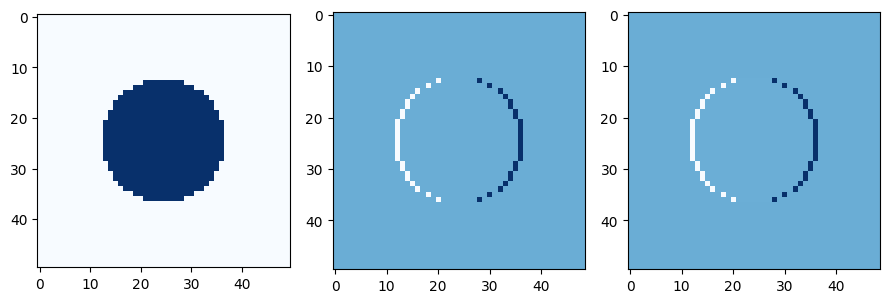

In [262]:
fig, ax = plt.subplots(1,3,figsize=(9,3))
ax = ax.flatten()
ax[0].imshow(image.numpy()[0],cmap=plt.cm.Blues) # 原始图像
ax[1].imshow(H.numpy()[0],cmap=plt.cm.Blues) # 卷积核运算后的结果
ax[2].imshow(y_hat.numpy()[0],cmap=plt.cm.Blues) # 拟合的卷积核的计算结果
plt.tight_layout()

打印模型的参数也可以看到，这**正是我们前面设计的垂直边缘检测卷积核的参数**

In [265]:
print("模型学习得到的卷积核参数：",tf.reshape(layer.weights,(1,2)).numpy())

模型学习得到的卷积核参数： [[ 0.93975633 -0.94345176]]


最后，我们讨论**感受野**（**receptive field**）的概念，卷积层的输出有时被称为特征映射，因为卷积层可以当作从一个输入映射到下一层隐藏空间的转换器，在卷积神经网络中，对于**某一层的任意位置元素** $x$，**其感受野指在前向推理过程中**，**可能影响** $x$ **值的所有元素**，**这些元素包含在** $x$ **之前所有层**，如下图所示：

<img src="./source/Chap3/感受野.png" width=800>

如果卷积核的宽度和高度大于 1，当我们把多层卷积计算堆叠时，**靠后层的每个单元的感受野就会增大**，如上图所示，第一层 $\boldsymbol{H}_1$ 每个单元的感受野大小为 4，而第二层 $\boldsymbol{H}_2$ 的感受野大小为 9，输入 $\boldsymbol{X}$ 任何一个元素的改变，都会改变  $\boldsymbol{H}_2$ 的值

因此，当我们想让一个特征图中的任意元素，能够**检测更广区域的输入特征时**，我们可以构建一个更深的卷积神经网络，随着层数加深，后面卷积层的感受野会不断扩大

**(2) 填充**

设想一下，当我们把一个 $5\times 5$ 的卷积核连续作用到一张 $32\times 32$ 的图像时，它会存在两个问题：
* 根据输出特征维度公式：
  $$
  (n_h - k_h + 1)\times (n_w - k_w + 1)
  $$
  图像的尺寸变换为 $(32,32)\to (28,28)\to (24,24)\to (20,20)\to (16,16)\to (12,12)\to \cdots$，随着层数的增加，图像的尺寸会快速缩减，而如果我们**尝试更大一些的卷积核，这种衰减速度还会更快**，这致使我们无法设计层数更深的CNN
* 来自图像边缘的像素参与卷积运算次数会远小于图像中心区域的像素，**随着层数的加深，累计丢失的边缘像素信息就越来越多**

解决上述问题的最简单方法为**填充**（**padding**），我们在输入特征的边界填充元素（通常填充 0），如下图所示：

<img src="./source/Chap3/填充.png" width=900>

通常，我们添加 $p_h$ 行填充（一半在顶部，一半在底部），$p_w$ 列填充（一半在左侧，一半在右侧）：
* 如果 $p_h$ 是偶数，则取 $p_h/2$ 在顶部，$p_h/2$ 在底部，$p_w$ 同理
* 如果 $p_h$ 是奇数，则取 $\lfloor p_h/2\rfloor $ 在顶部，$p_h - \lfloor p_h/2\rfloor $ 在底部，$p_w$ 同理

此时，输出的维度为：
$$
(n_h - k_h + p_h + 1)\times (n_w - k_w + p_w + 1)
$$

许多情况下，我们考虑设置 $p_h = k_h -1, p_w = k_w - 1$，这样能够**使得输入和输出具有相同的高度和宽度**（即保持维度像素维度不发生改变），为了**让上下左右填充的像素数量相等，因此卷积核的高宽** $k_h,k_w$ **通常取奇数** 1，3，5 或 7

下面的函数`transform_Conv2d()`帮助我们**将二维图像数据添加批量维度和通道维度**，便于`Conv2d()`层处理，然后**再转换为二维矩阵输出**，该函数已经写入`./source/code/ch3.py`中

In [267]:
def transform_Conv2d(Conv2dLayer, X : tf.Tensor):
    # 添加批量维度和通道维度
    X = tf.reshape(X, (1,) + X.shape + (1,))
    Y = Conv2dLayer(X) # 进行卷积运算
    # 变换回原来的形状
    Y = tf.reshape(Y, Y.shape[1:3])
    return Y

Tensorflow的`Conv2d()`层中，指定`padding = "same"`就可以启用填充，填充会**根据卷积核的大小**`kernel_size`**自动适应填充的行数和列数** $p_h,p_w$，**以使得输出维度和输入维度相等**

In [273]:
# 创建卷积层，使用填充 padding
# 这里每边都填充了 1 行和 1 列，因此 p_h = p_w = 2
# 此时 p_h = p_w = 3 - 1 = 2
layer = tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding="same")
X = tf.random.uniform(shape=(8,8))
ch3.transform_Conv2d(layer,X).shape

TensorShape([8, 8])

上面的例子中，因为 $k_h = k_w = 3$，因此行和列都填充了两行以使得输出维度不变，下面如果我们将卷积核改为 $5\times 3$，则padding将会对行填充 $p_h = k_h - 1 = 5 - 1 = 4$ 行，而列填充 $p_w = k_w - 1 = 2$ 列

In [278]:
layer = tf.keras.layers.Conv2D(1, kernel_size=(5,3), padding="same")
X = tf.random.uniform(shape=(8,8))
ch3.transform_Conv2d(layer,X).shape

TensorShape([8, 8])

**(3) 步幅**

在计算互相关时，**卷积窗口从输入张量的左上角开始，向下、向右滑动**，在前面的例子中，我们**默认每次滑动一个元素**，但是，有时候为了**高效计算或是缩减采样次数**，卷积窗口可以跳过中间位置，**每次滑动多个元素**，这就是**步幅**（**stride**）
* 考虑一个 $5\times 5$ 的卷积核，**当卷积核每次只向右移动一个像素时，参与运算的像素只有 5 个发生改变**，因此每次卷积核的采样输入特征存在很大冗余，导致采样效率较低

下图演示了**水平步幅为2，垂直步幅为3**的卷积计算示意图：

<img src="./source/Chap3/步幅.png" width=900>

从上面的图中可以看到，**当步幅比较大时，输入的部分像素不会参与卷积运算**，假设垂直步幅为 $s_h$，水平步幅为 $s_w$，则输出的形状会变为：
$$
\lfloor(n_h - k_h + p_h + s_h) / s_h\rfloor \times \lfloor(n_w - k_w + p_w + s_w) / s_w\rfloor
$$

加入我们在填充时设置了步幅 $p_h = k_h-1$ 以及 $p_w = k_w - 1$，则输出形状为：
$$
\lfloor(n_h + s_h - 1) / s_h  \rfloor \times \lfloor(n_w + s_w - 1) / s_w\rfloor
$$

当输入的特征维度 $n_h,n_w$ 可以被步幅 $s_h,s_w$ 整除时，则输出形状为：
$$
(n_h / s_h) \times (n_w / s_w)
$$

In [280]:
layer = tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding="same",strides=2)
X = tf.random.uniform(shape=(8,8))
ch3.transform_Conv2d(layer,X).shape

TensorShape([4, 4])

我们来看一个复杂一点的情况：
* 输入特征 $\boldsymbol{X}$ 维度 $8\times 8$
* 卷积核大小 $3\times 5$
* 不使用填充
* 步幅大小为 $3\times 4$

请问，输出特征的维度是多少？

In [282]:
layer = tf.keras.layers.Conv2D(1, kernel_size=(3,5), padding="same",strides=(3,4))
X = tf.random.uniform(shape=(8,8))
ch3.transform_Conv2d(layer,X).shape

TensorShape([3, 2])

最后，我们对填充和步幅做简单说明：
* 当填充 $p_h = p_w = p$ 时，简称填充是 $p$，同理，当步幅 $s_h = s_w = s$ 时，简称步幅是 $s$
* Tensorflow默认 $p  = 0$（即不填充），步幅为 $s = 1$
* **实践中，我们很少会使用不一致的填充和步幅**

**(4) 多输入和多输出通道**

上述讨论仅展示了单个输入通道和单个输出通道的简化例子，此时输入和输出都是二维张量，下面我们**增加通道维度，将它们扩展到三维张量**，前文提到，我们希望每个像素 $(i,j)$ 能有**一组特征表示，这就是通道维度的含义**

当输入 $\boldsymbol{X}\in\mathbb{R}^{n_h \times n_w\times c}$ 时，**需要** $c$ **个卷积核构成卷积层**，以便于输入特征进行互相关运算，卷积核参数 $\boldsymbol{V}\in\mathbb{R}^{k_h\times k_w\times c}$，**每个通道与其对应的卷积核进行互相关运算后**，**再将** $c$ **个输出对应位置像素的值相加**，如下图所示：

<img src="./source/Chap3/多输入通道.png" width=1100>

我们来定义多输入通道的互相关运算`corr2d_multi_in()`，该函数已经写入`./source/code/ch3.py`

In [2]:
def corr2d_multi_in(X : tf.Tensor, kernel : tf.Tensor):
    # 假设 X 和 kernel 的第 0 个维度表示通道维度
    # 先遍历 X 和 kernel 的通道维度（第 0 个维度）
    # 再把结果加在一起，求和在第 0 个维度及逆行，axis = 0
    return tf.reduce_sum([ch3.corr2d(x, k) for x, k in zip(X, kernel)], axis=0)

我们创建上图中的三维输入特征和三维卷积核，测试多通道输入的卷积运算

In [2]:
# 创建输入特征
X = tf.constant([[[0.0, 1.0, 2.0], 
                  [3.0, 4.0, 5.0], 
                  [6.0, 7.0, 8.0]],
                 [[1.0, 2.0, 3.0], 
                  [4.0, 5.0, 6.0], 
                  [7.0, 8.0, 9.0]]])
# 创建卷积核
kernels = tf.constant([[[0.0, 1.0], 
                        [2.0, 3.0]], 
                       [[1.0, 2.0], 
                        [3.0, 4.0]]])
print("输入 X 的维度：",X.shape)
print("卷积核的维度：",kernels.shape)

输入 X 的维度： (2, 3, 3)
卷积核的维度： (2, 2, 2)


In [3]:
ch3.corr2d_multi_in(X, kernels)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 56.,  72.],
       [104., 120.]], dtype=float32)>

到目前为止，不论有多少输入通道，我们还只有一个输出通道，而**每一层有多个输出通道是至关重要的**，在**实践中，随着神经网络层数的加深，我们常会增加输出通道的数量**：
* 我们可以将**每个输出通道看作对不同图像特征的提取**（例如有的通道做边缘检测，有的通道进行图像锐化）
* **训练时，每个通道不是独立学习的**。因此，**多输出通道并不仅是学习多个单通道的检测器**

用 $c$ 表示输入的通道数量，$d$ 表示输出通道的数量，则**多输入多输出卷积核的是一个四维张量**，**维度包含** $d\times c\times k_h\times k_w$，每个输出通道的卷积核维度为 $c\times k_h\times k_w$，用于处理多通道的特征输入

我们来定义**多输入多输出通道的互相关运算**`corr2d_multi_in_out()`，该函数已经写入`./source/code/ch3.py`

In [4]:
def corr2d_multi_in_out(X : tf.Tensor, kernel : tf.Tensor):
    # 假设 X 的第 0 个维度表示输入通道维度
    # 假设kernel 的第 0 个维度表示输出通道维度，第 1 个维度表示输入通道数量
    # 先遍历 kernel 的输出通道维度（第 0 个维度）
    # 把每个输出通道 kernal 与 X 做 corr2d_multi_in
    # 最后把多个输出通道用 tf.stack 拼接在一起
    return tf.stack([ch3.corr2d_multi_in(X, k) for k in kernel], axis=0)

我们将刚才创建的三维卷积核，分别元素递增，然后拼接成为一个 $d=4$ 输出通道的四维卷积核

In [5]:
# 创建多输出通道卷积核
kernels = tf.stack((kernels, kernels+1, kernels+2, kernels+3), axis=0)
print(kernels.shape)

(4, 2, 2, 2)


In [6]:
# 进行多输出通道的运算
ch3.corr2d_multi_in_out(X, kernels)

<tf.Tensor: shape=(4, 2, 2), dtype=float32, numpy=
array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]],

       [[116., 156.],
        [236., 276.]]], dtype=float32)>

多输入多输出卷积核自然也使用**填充和步幅**，在`tf.keras.layers.Conv2d()`的卷积层中：
* 第一个参数`filters`用于**指定该卷积层的输出通道数量**
* 我们**无需指定该卷积层输入的通道数量**，`Tensorflow`会自动推理该层输入的通道维度
* `Tensorflow`这种自动推理每层输入特征维度的机制包含在各种计算层中，例如`Dense()`，但注意，其他的深度学习框架可能没有提供这种推理功能，例如`Pytorch`，`Pytorch`中用户需要指明每一层的输入特征维度

最后，我们介绍一种特殊的卷积层，$1\times 1$ **卷积层**：
* **卷积的本质是有效提取相邻像素间的相关特征**，而 $1\times 1$ 显然没有该作用
* 这看起来似乎没有多大意义，但 $1\times 1$ 在特殊场合十分有用，尤其是深层网络的设计

$1\times 1$ 卷积**失去了卷积层的识别相邻像素相互作用**的特有能力，**它的计算只发生在通道维度上**，$1\times 1$ 卷积层等价于作用在每个像素 $(i,j)$ 上的一种**全连接神经网络**：
* 他将每个像素的输入通道 $c$ 全连接到输出通道 $d$ 上
* 这种全连接的权重矩阵 $W\in\mathbb{R}^{c\times d}$，与所作用的像素索引 $(i,j)$ 无关

我们可以用全连接层，来等价实现 $1\times 1$ 卷积层运算`corr2d_multi_in_out_1x1()`，该函数已经写入`./source/code/ch3.py`

In [2]:
def corr2d_multi_in_out_1x1(X : tf.Tensor, kernel : tf.Tensor):
    # X 是三维张量，维度 (c, n_h, n_w)
    # kernel 是四维张量，维度 (d, c, 1, 1)
    c, n_h, n_w = X.shape
    d = kernel.shape[0]
    X = tf.reshape(X, (c, n_h*n_w)) # 将像素所在的两个维度合并，变换为 (c, n_h*n_w)
    kernel = tf.reshape(kernel, (d, c)) # 转换维度为 (d, c)
    # 全连接层中的矩阵乘法
    Y = kernel @ X # 输出维度 (d, n_h*n_w)
    # 恢复像素所在的两个维度
    Y = tf.reshape(Y, (d, n_h, n_w))
    return Y

In [3]:
# 创建输入和 1x1 卷积核
X = tf.random.normal(shape=(3, 5, 5))
kernels = tf.random.normal(shape=(2, 3, 1, 1))

# 利用全连接层实现的 1x1 卷积层
Y1 = ch3.corr2d_multi_in_out_1x1(X, kernels)
# 多输入多输出卷积层
Y2 = ch3.corr2d_multi_in_out(X, kernels)

对比运算结果，对于 $1\times 1$ 卷积，**使用全连接层实现的卷积运算和普通的卷积运算结果相同**

In [5]:
tf.abs(Y1 - Y2)

<tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float32)>

在我们本节的实验中，做出一个说明：
* 我们自定义的多输入多输出通道的计算函数，都**假设通道维度是特征的第 0 个维度**
* `Tensorflow`的`Conv2d()`等与卷积相关的计算层，采用的是**通道最后**（**channels-last**）假设，即**通道维度是特征的最后一个维度**，这和我们实验中实现的有区别，使用时请注意
* 在使用其他深度学习框架时，请**注意它们的实现中，通道维度在特征的第几个维度**，必要时，请使用`tf.transpose()`函数，变换特征的轴的排列以改变通道的排列位置

**(5) 汇聚层**

通常在处理图像时，我们希望**让后面隐藏层的每个像素表示拥有更大的感受野**，使得最终**最后一层的隐藏特征表示能涵盖整个输入图像的特征**，**汇聚层**（**pooling**）通过逐渐**聚合信息**，生成越来越粗糙的映射，最终**实现学习输入图像全局表示的目标**

此外，在检测较底层的特征时（例如前面提到的边缘检测的例子），我们通常希望这些特征保持某种程度上的**平移不变性**，具体地，当我们把整个输入图像向右移动一个像素时：
$$
\boldsymbol{X}_{i,j} \to \boldsymbol{X}_{i,j-1}
$$

**新的图像的输出在经过卷积运算后可能会大不相同**，而在现实中，图像会因为拍摄角度的移动，任务物体的像素偏移都是十分常见的，**汇聚层通过对特征的粗糙化处理，保留图像中最关键的信息，使得后续卷积层对输入特征的扰动不太敏感**
* 这种输入图像的扰动在现实中十分常见，例如光照强度、对比图、图像倾斜角度、图像高斯模糊等等

因此，简单来说，**汇聚层有两个主要作用**：
* **降低卷积层对像素位置的敏感性**
* **降低对图像空间降采样表示的敏感性**，以获得输入图像的全局特征表示

与卷积层不同，汇聚层运算由一个固定形状的窗口组成，**汇聚层窗口在图像上的滑动也可以指定步幅**，**汇聚层不包含任何可以学习的参数**，我们有两种常见的汇聚层算子：
* **最大汇聚层**：每次计算输出是当前窗口中所有元素的最大值
* **平局汇聚层**：每次计算输出是当前窗口中所有元素的平均值

与卷积层运算相同的，池化层窗口也从图像的左上角开始，从左向右，从上到下在输入张量上华东，如下图所示：

<img src="./source/Chap3/汇聚层.png" width=800>

汇聚层的这种运算被称为**池化**，因此汇聚层在有些地方会被称为**池化层**

回到开始的图像平移例子，假设我们使用了一个 $2\times 2$ 的最大汇聚层，那么无论 $\boldsymbol{X}_{i,j}$ 和 $\boldsymbol{X}_{i,j+1}$ 的值是否相同，汇聚层在像素 $(i,j)$ 位置上的输出都不会改变，这意味着**使用** $2\times 2$ **的最大汇聚层**，**输入在高度和宽度上移动一个元素，卷积层依然可以识别出相同的模式**

下面的`pool2d()`函数演示了汇聚层的计算过程，该函数已经写入`./source/code/ch3.py`

In [2]:
def pool2d(X : tf.Tensor, pool_size : tuple, mode : str="max"):
    p_h, p_w = pool_size # 汇聚窗口大小
    Y = tf.Variable(tf.zeros(shape=(X.shape[0] - p_h + 1, X.shape[1] - p_w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == "max":
                Y[i,j].assign(tf.reduce_max(X[i:i+p_h, j:j+p_w]))
            elif mode == "mean":
                Y[i,j].assign(tf.reduce_mean(X[i:i+p_h, j:j+p_w]))
    
    return Y

In [3]:
# 创建输入张量
X = tf.constant([[0.0, 1.0, 2.0], 
                 [3.0, 4.0, 5.0], 
                 [6.0, 7.0, 8.0]])
# 最大池化运算
ch3.pool2d(X, pool_size=(2,2), mode="max")

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[4., 5.],
       [7., 8.]], dtype=float32)>

与卷积运算一样，汇聚层算子会改变输入的形状，因此汇聚层也可以使用**填充和步幅**，从而控制汇聚层输出的形状大小，下面我们使用`tf.keras.layers.MaxPool2d()`来演示填充和步幅，注意他和`Conv2d()`一样，输入是四维张量，第 0 个维度是样本量，最后一个维度是通道维度

In [16]:
# 创建输入特征
X = tf.reshape(tf.range(16, dtype=tf.float32), (1, 4, 4, 1))
tf.reshape(X, (4, 4))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]], dtype=float32)>

默认情况下，`Tensorflow`框架中的**步幅与汇聚窗口的大小相同**，因此，如果我们使用形状为 $3\times 3$ 的汇聚窗口，那么默认情况下，我们得到的**步幅形状为(3, 3)**

In [17]:
layer = tf.keras.layers.MaxPool2D(pool_size=(3,3))
layer(X)

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[10.]]]], dtype=float32)>

`Tensorflow`框架中汇聚层默认不使用填充padding，**填充和步幅都可以手动设定**

In [51]:
# 手动设置 padding
# 第 0 和 第 3 维度不使用填充
# 仅在中间第 1, 2 维度上使用填充
# 在下面填充 2 行，在右填充 2 列
padding = tf.constant([[0, 0], [0, 2], [0, 2], [0, 0]])
X_padded = tf.pad(X, padding, mode="constant") # 使用常数 0 填充
tf.reshape(X_padded, (6, 6))

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  0.,  0.],
       [ 4.,  5.,  6.,  7.,  0.,  0.],
       [ 8.,  9., 10., 11.,  0.,  0.],
       [12., 13., 14., 15.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)>

In [52]:
layer = tf.keras.layers.MaxPool2D(pool_size=(3,3), padding="valid", strides=2)
layer(X_padded)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[10.],
         [11.]],

        [[14.],
         [15.]]]], dtype=float32)>

回忆在`Tensorflow`中，当指定`padding = "same"`启用填充后，填充数量 $p_h = k_h - 1, p_w = k_w - 1$，此时汇聚层窗口大小 $k_h = k_w = 3$，因此填充 $p_h = p_2 = 2$，对于汇聚层，`Tensorflow`会**将填充布置在图像下方和右侧，而不是将它们平分放置在上下左右，这与卷积层的填充不太相同**，这**等价于上面我们手动填充的结果**

In [53]:
layer = tf.keras.layers.MaxPool2D(pool_size=(3,3), padding="same", strides=2)
layer(X)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[10.],
         [11.]],

        [[14.],
         [15.]]]], dtype=float32)>

最后我们讨论汇聚层的**多输入通道问题**，汇聚层算子**独立作用在三维张量输入的每个通道维度上**，并且**不会像卷积层一样将多个输入通道计算的结果加和汇总**，因此，汇聚层的输出通道数量 $d$ 与输入通道数量 $c$ 相等

我们将 $\boldsymbol{X}, \boldsymbol{X}+1, \boldsymbol{X}+2$ 拼接组成一个三通道输入的特征

In [55]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (1, 4, 4, 1))
X = tf.concat([X, X+1, X+2],axis=3)
X.shape

TensorShape([1, 4, 4, 3])

随后，我们按照如上的方式进行填充，然后进行汇聚层运算，可以看到汇聚层的输出依然是三个通道

In [57]:
# 进行填充
padding = tf.constant([[0, 0], [0, 2], [0, 2], [0, 0]])
X_padded = tf.pad(X, padding, mode="constant") # 使用常数 0 填充
# 汇聚层运算
layer = tf.keras.layers.MaxPool2D(pool_size=(3,3), padding="valid", strides=2)
Y = layer(X_padded)
Y

<tf.Tensor: shape=(1, 2, 2, 3), dtype=float32, numpy=
array([[[[10., 11., 12.],
         [11., 12., 13.]],

        [[14., 15., 16.],
         [15., 16., 17.]]]], dtype=float32)>

上面的结果乍一看与前面实验的结果不相同，原因在于**通道维度在最后一个维度，不便于观察**，通过`tf.transpose()`方法，可以**将通道维度所在轴（最后一个维度）变换到第 0 个维度**，就可以观察到三通道的汇聚层输出了
* 可以看到第一个通道的输出结果，与上面实验的计算结果相同
* 其他两个通道的输出，等价于在上一个通道输出的结果上加 1

In [59]:
# Y[0] 取出第一个样本，相当于去除掉了样本维度
tf.transpose(Y[0], perm=(2,0,1))

<tf.Tensor: shape=(3, 2, 2), dtype=float32, numpy=
array([[[10., 11.],
        [14., 15.]],

       [[11., 12.],
        [15., 16.]],

       [[12., 13.],
        [16., 17.]]], dtype=float32)>

到此，所有卷积神经网络的基本算子介绍完毕，我们下面可以把这些算子组装，构成一个完整的卷积神经网络模型了

### **3.2.4 卷积神经网络LeNet**

我们学习了构建一个卷积神经网络的所需组件，对于`CIFAR-100`数据集，与第一节不同，现在我们可以直接给模型提供 $32\times 32\times 3$ 的特征输入，而无需利用`Flatten()`将其展开为向量了

下面介绍的**LeNet**是**最早发布的卷积神经网络架构之一**，因其在计算机视觉任务中的高效性能而受到广泛关注，这个模型由深度学习奠基人之一Yann LeCun在1989年提出（并以其名字命名），模型目标就是处理图像分类任务，当时模型被设计用于处理**手写数字识别**问题（即`MNIST`数据集），LeNet在美国被**广泛用于自动取款机中，帮助识别处理支票上的数字**

总体来看，LeNet（或者说LeNet-5版本）由两个部分组成：
* 卷积编码器：由两个卷积层组成
* 全连接神经网络：由三个全连接层组成

LeNet在处理手写数字识别问题时的模型框架如下图所示：

<img src="./source/Chap3/LeNet.svg" width=1100>

每一个**卷积处理块儿**包含三个核心元素：
* 一个卷积层提取特征
* 一个`sigmoid`激活函数做非线性变换
* 一个**平均汇聚层**做特征汇聚

注意，虽然现在的CNN中使用更有效的`ReLU`激活函数和最大汇聚层，但在当时还没有出现这两种概念

LeNet的具体的计算结构如下：
* 第一个卷积块儿：
  * 使用 $5\times 5$ 卷积核，使用`sigmoid`激活函数，使用填充，步幅为 1
  * 具有 $6$ 个输出通道
  * 使用 $2\times 2$ 平均汇聚层，步幅为 2
* 第二个卷积块儿：
  * 使用 $5\times 5$ 卷积核，使用`sigmoid`激活函数，步幅为 1
  * 具有 $16$ 个输出通道
  * 使用 $2\times 2$ 平均汇聚层，步幅为 2
* 第三个稠密全连接网络：
  * 为了**将上面卷积块的输出传递给全连接网络**，我们必须**展平每个样本**，利用`Flatten()`算子得到向量
  * LeNet使用 `[120, 84, 10]` 的全连接网络，隐藏层使用`sigmoid`激活函数
  * 由于手写数字识别最后是 10 分类问题，因此模型最后一层输出维度是 10 个神经元
  * 执行分类任务前，可以利用 `Softmax` 函数将结果转换为概率

下图更直观的展示了LeNet的神经网络结构图：

<img src="./source/Chap3/LeNet结构.svg" width=200>

如果我们想要将 LeNet 转换处理`CIFAR-100`的分类任务，我们需要**将模型最后一层的输出问题更改为 100**，其他处理部分保持不变，我们来定义`LeNet`模型

In [52]:
def LeNet(input_shape : tuple, num_class : int, activation : str="sigmoid"):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(6,kernel_size=5,padding="same",activation=activation),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(16,kernel_size=5,activation=activation),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation=activation),
        tf.keras.layers.Dense(84,activation=activation),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ])

实例化模型，然后我们可以通过访问`model.summary()`来查看模型每一层的结构信息：
* 注意**每一层计算后的隐藏特征的维度**
* 注意**每一层模型的参数数量**，哪些层是没有可训练参数的

In [53]:
# 实例化模型，指定输入图像的形状，以及输出类别的数量
model = LeNet(input_shape=(32,32,3),num_class=100,activation="sigmoid") 
model.summary() # 查看模型结构信息

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_22 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_23 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_14 (Flatten)        (None, 576)               0         
                                                                 
 dense_45 (Dense)            (None, 120)             

接下来，创建数据集，调用`ch3.train()`函数训练模型，查看模型表现

In [54]:
# 导入 CIFAR-100 数据集
(x_train, y_train), (x_test, y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


当使用`sigmoid`作为激活函数，创建模型开始训练时，如果学习率或其他超参数设置的不是很合理，很大可能你会遇到下面的情况，**模型训练不动！**

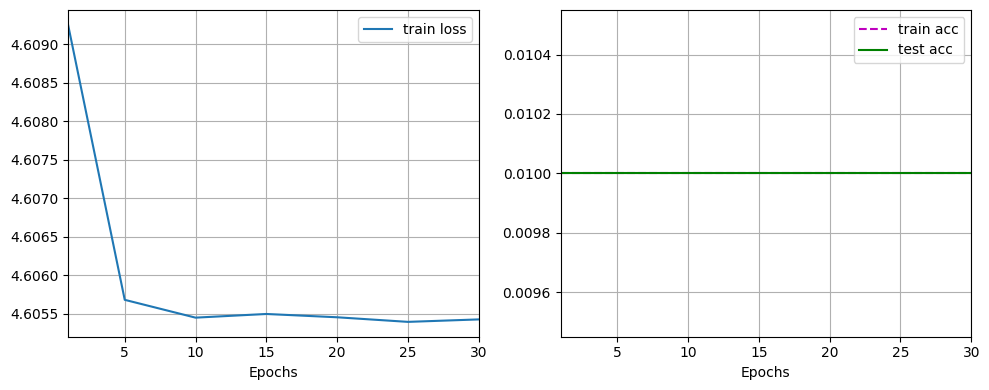

In [78]:
# 实例化模型
model = LeNet(input_shape=(32,32,3),num_class=100,activation="sigmoid") 
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=30,verbose=5,lr=0.5)

当模型结构变得复杂，模型的参数量很多时，非常容易出现**数值稳定性**的问题，你可以抽象理解为**损失函数** $\ell$ **关于模型参数** $\Theta$ **的超高维曲面是非常凹凸不平的**，模型很难找到正确的优化方向，出现这种优化中的数值不稳定的原因有多种，`sigmoid`存在的**梯度消失问题**也是主要原因之一

因此，一种训练这种复杂深度学习模型的技巧叫做**模型预热**，或者**模型热身**（**Warm Up**），简单来说，训练模型分为两步：
* **第一步**：以一个**较小的学习率**，让模型迭代少数几轮，该过程即为**热身阶段**
* **第二步**：将学习率调整为正常范围，让模型开始正式训练阶段的迭代

我们来重新尝试训练上面的模型

**(1) 模型预热**

我们设置学习率`lr=0.001`，让模型迭代10次

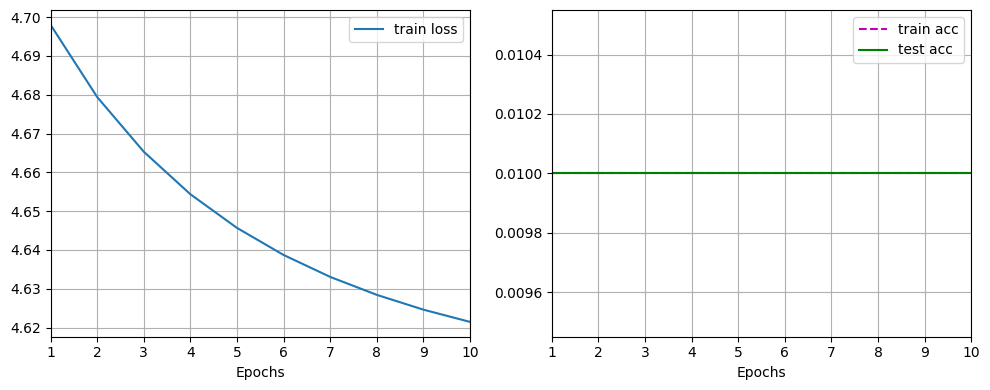

In [79]:
# 重新实例化模型
model = LeNet(input_shape=(32,32,3),num_class=100,activation="sigmoid") 
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=10,verbose=1,lr=0.001)

**(2) 正式训练**

接下来，调整学习率为`lr = 0.1`，开始正式的50轮迭代

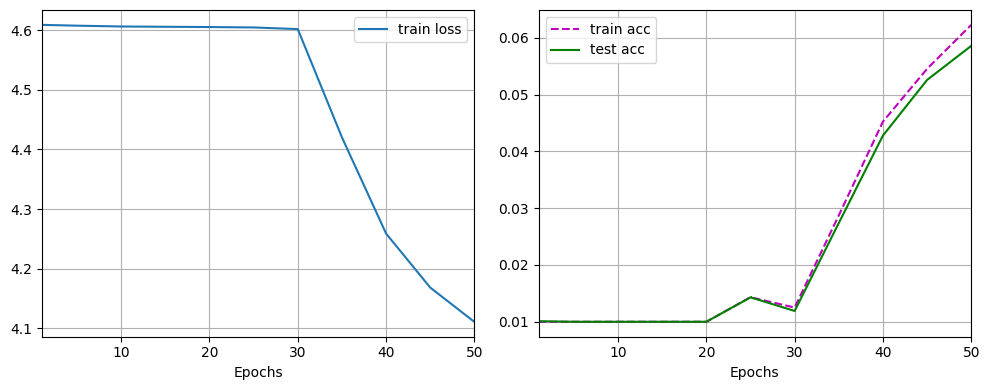

In [80]:
# 调整学习率，开始正式训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=50,verbose=5,lr=0.1)

可以看到，模型在经过多轮迭代后，仿佛突然“**开窍**”，损失快速下降，模型准确率快速上升，这说明**模型的学习开始步入正轨**

当我们将激活函数更换为`ReLU`激活函数时，上面训练过程中出现的数值不稳定问题会得到缓解，模型的训练会更加容易，梯度消失问题得到缓解是其中的一种解释，因此现代神经网络中，`ReLU`激活函数更受欢迎

稍后，我们介绍另一种重要的深度学习基本结构，**批量归一化**（**BatchNorm**），它**进一步改进了深度学习模型训练的稳定性**

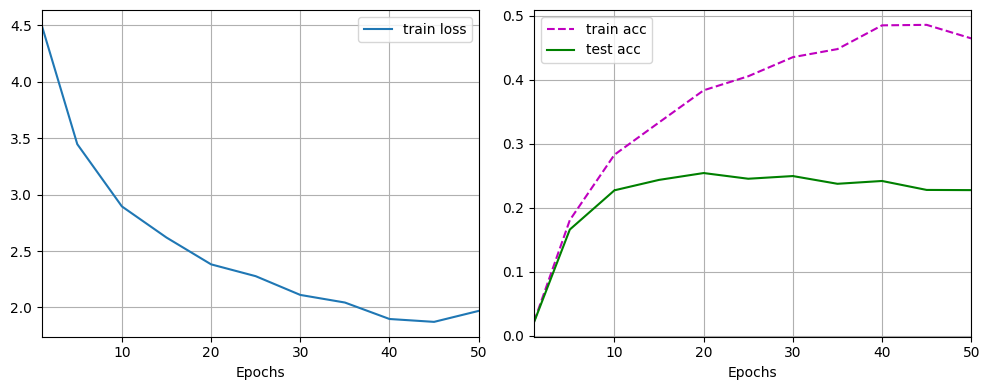

In [73]:
# 创建模型，使用 ReLU 激活函数
model = LeNet(input_shape=(32,32,3),num_class=100,activation="relu") 
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=50,verbose=5,lr=0.2)

从图中观察可以得出两点结论：
* 卷积神经网络**LeNet对图像的处理能力明显增强**，模型在训练集上的准确率显著高于`BaselineModel`
* 由于模型**没有引入正则化技术，模型在训练集上出现了严重的过拟合**

----

### **练习**

1. 模仿本节中设计的垂直边缘检测卷积，**手动设计一个水平边缘检测卷积**

2. 我们再一次深入讨论卷积的计算问题、
   1. 利用 `Tensorflow` 的自动梯度，尝试让我们在3.2.3节中，自定义的 `corr2d()` 的卷积计算输出对卷积核 `kernal` 求梯度，结果是什么？（你可以直接查看 `ch3.corr2d` 的代码）
   2. 理解卷积的运算过程后，尝试改变输入张量`X`和卷积核张量 `kernel` （或者在输入张量和卷积核张量的基础上加工其他变量），将互相关运算 `corr2d()` 表示为**矩阵乘法**
      * 定义**矩阵乘法卷积运算** `MatMultiplyCorr2d()` ，当给定相同的输入和卷积核时，它的输出结果应该与 `corr2d()` 完全相同
      * 函数 `MatMultiplyCorr2d()` 的接口和参数说明已经定义在下方
   3. 尝试让 `MatMultiplyCorr2d()` 的计算输出对卷积核 `kernal` 求梯度，这时候梯度存在吗？

In [ ]:
def MatMultiplyCorr2d(X : tf.Tensor, kernel : tf.Tensor):
    """
    MatMultiplyCorr2d(X : tf.Tensor, kernel : tf.Tensor)
        矩阵乘法实现卷积运算
    
    Parameters
    ----------
    X : tf.Tensor
        输入特征，二维张量，维度`(n_h, n_w)`
    kernel : tf.Tensor
        卷积核，二维张量，维度`(k_h, k_w)`
    """
    # 在下面编写你的代码
    # 你可以参考 corr2d 的实现逻辑
    ...

3. 完成下面的计算
   1. 假设输入图像的大小是 $16\times 16$，卷积核尺寸 $3\times 5$，使用自动填充（即设定`padding = "same"`），步幅大小 $2\times 2$，则输出图像的大小是多少？
   2. 考虑如下的卷积神经网络结构：
      ```python
      model = tf.keras.models.Sequential([
         tf.keras.layers.Input(shape=(32,32,3)),
         # 第一层卷积
         tf.keras.layers.Conv2D(6,kernel_size=5,padding="same",activation="relu"),
         tf.keras.layers.AvgPool2D(pool_size=2, strides=2),

         # 第二层卷积
         tf.keras.layers.Conv2D(16,kernel_size=3,activation="relu"),
         tf.keras.layers.AvgPool2D(pool_size=2, strides=2),

         # 第三层卷积
         tf.keras.layers.Conv2D(32,kernel_size=3,activation="relu")
      ])
      ```
      请问，**模型最后一层卷积输出的每个像素的感受野是多大**？